In [1]:
from src.dataset.create_dataset import *
from src.model.classifiers import GaussianNBModel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import time
import os
import pyspark
from pyspark.sql import SparkSession
from pyspark import StorageLevel
from pyspark.sql.types import *

In [2]:
sns.set_style('white')

In [3]:
appName = 'Yellow-Taxi-Analysis'
token = os.environ['GOOGLE_APPLICATION_CREDENTIALS']
BUCKET_NAME = 'yellow_taxi_vineet'

spark = SparkSession \
    .builder \
    .master('local[*]') \
    .appName(appName) \
    .getOrCreate()

spark.conf.set('spark.sql.execution.arrow.enabled', 'true')
spark.conf.set('spark.sql.execution.arrow.maxRecordsPerBatch', '10000')
spark

In [4]:
df = spark.read.csv(f'gs://{BUCKET_NAME}/tripdata/yellow_tripdata_2021-*.csv', header=True, inferSchema=True)

df.printSchema()
df.createOrReplaceTempView('trip_table')

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)



### Number of entries in the dataset

In [5]:
df.count()

30904072

### Five number summary of fare_amount, trip_distance, total_amount, tip_amount, passenger_count:


In [6]:
spark.sql(
    'SELECT fare_amount, trip_distance, total_amount, tip_amount, passenger_count FROM trip_table').describe().show()

+-------+------------------+-----------------+------------------+------------------+------------------+
|summary|       fare_amount|    trip_distance|      total_amount|        tip_amount|   passenger_count|
+-------+------------------+-----------------+------------------+------------------+------------------+
|  count|          30904072|         30904072|          30904072|          30904072|          29425377|
|   mean|13.519365664815796|6.922726195434684|19.696337035317203|2.3411668222883693|1.4274779215233164|
| stddev|178.98936097415236|698.3826175595799|179.19494366216398| 2.829036847287313|1.0333720138448683|
|    min|            -758.0|              0.0|            -951.0|           -333.32|               0.0|
|    max|         818283.44|        351613.36|         818286.74|           1140.44|             112.0|
+-------+------------------+-----------------+------------------+------------------+------------------+



As we can see, there are a lot of outliers in the fare_amount, trip_distance and total_amount columns. We can see that the fare_amount/total_amount/trip_distance are the most skewed variable. The min and max values are very low and high for a simple taxi fare.

### How does taxi usage change over a month

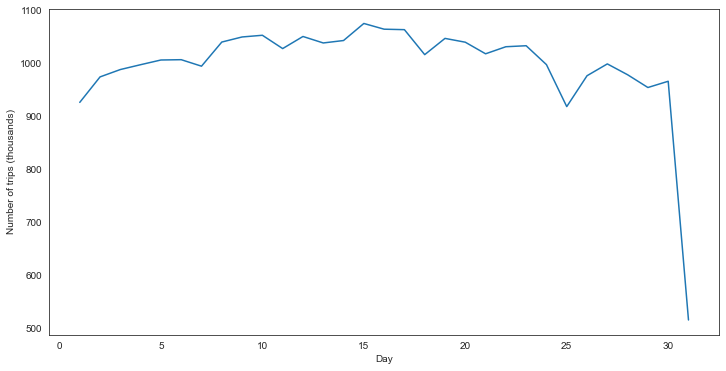

In [7]:
viz = spark.sql("""
SELECT
    day(DATE_TRUNC('DD', TO_DATE(tpep_pickup_datetime))) AS day,
    ROUND(COUNT(1)/1000, 2) AS trip_count
FROM
    trip_table
GROUP BY
    day
""").toPandas()

fig = plt.figure(figsize=(12, 6))
ax = sns.lineplot(x='day', y='trip_count', data=viz, color='#1f77b4')
ax.set_xlabel('Day')
ax.set_ylabel('Number of trips (thousands)')
plt.show()

### Most popular months in year 2021 for taxi trips

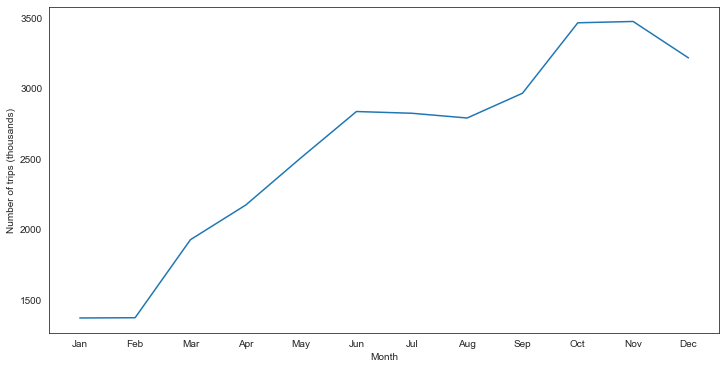

In [30]:
viz = spark.sql("""
SELECT
    month(DATE_TRUNC('MM', TO_DATE(tpep_pickup_datetime))) AS month,
    ROUND(COUNT(1)/1000, 2) AS trip_count
FROM
    trip_table
GROUP BY
    month
""").toPandas()

fig = plt.figure(figsize=(12, 6))
ax = sns.lineplot(x='month', y='trip_count', data=viz, color='#1f77b4')
ax.set_xlabel('Month')
ax.set_ylabel('Number of trips (thousands)')
ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] ,['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

### How trips are distributed by day of the week

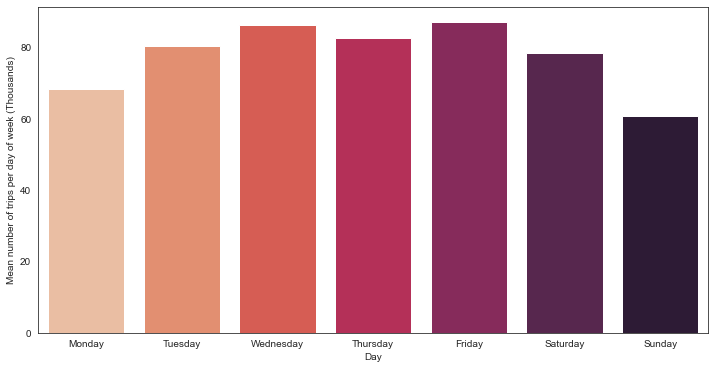

In [52]:
viz = spark.sql("""
SELECT
    TO_DATE(tpep_pickup_datetime) AS pickup_time,
    DATE_FORMAT(tpep_pickup_datetime, 'EEEE') AS day,
    ROUND(COUNT(*)/1000, 2) AS trip_count
FROM
    trip_table
GROUP BY
    pickup_time,
    day
""").toPandas()

mean_trips_week_day = viz.groupby('day').agg({'trip_count': 'mean'}).reset_index()
mean_trips_week_day = mean_trips_week_day.set_index('day').reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).reset_index()

fig = plt.figure(figsize=(12, 6))
ax = sns.barplot(x='day', y='trip_count', data=mean_trips_week_day, palette='rocket_r')
ax.set_xlabel('Day')
ax.set_ylabel('Mean number of trips per day of week (Thousands)')
plt.show()

In [62]:
spark.sql("""
SELECT
    tpep_pickup_datetime AS pickup_time,
    DATE_FORMAT(tpep_pickup_datetime, 'EEEE') AS day,
    HOUR(tpep_pickup_datetime) AS hour,
    ROUND(COUNT(*)/1000, 2) AS trip_count,
    MEAN(trip_distance) AS mean_distance,
    ROUND(MEAN((unix_timestamp(tpep_dropoff_datetime) - unix_timestamp(tpep_pickup_datetime))/60), 2) AS mean_duration,
    ROUND(MEAN(trip_distance/((unix_timestamp(tpep_dropoff_datetime) - unix_timestamp(tpep_pickup_datetime))/3600)),2) AS mean_speed
FROM
    trip_table
GROUP BY
    pickup_time, day, hour
""")

pickup_time,day,hour,trip_count,mean_distance,mean_duration,mean_speed
2021-03-01 00:03:28,Monday,0,0.0,6.2,12.02,30.96
2021-03-01 01:59:52,Monday,1,0.0,0.8,2.3,20.87
2021-03-01 04:46:49,Monday,4,0.0,3.3,11.57,17.12
2021-03-01 05:41:51,Monday,5,0.0,0.89,4.63,12.87
2021-03-01 05:56:45,Monday,5,0.0,0.43,2.18,11.82
2021-03-01 06:27:47,Monday,6,0.0,2.6,10.24,15.66
2021-03-01 06:49:07,Monday,6,0.0,1.725,7.91,13.37
2021-03-01 06:16:22,Monday,6,0.0,1.14,2.77,24.72
2021-03-01 06:49:10,Monday,6,0.0,1.17,6.17,11.38
2021-03-01 06:20:16,Monday,6,0.0,1.54,6.68,13.83


In [ ]:
## Preprocess (load data -> clean data -> save preprocessed data to cloud)
!python../ main / preprocess.py

In [ ]:
## Generate the features (generate features -> save the new dataframe with features to cloud)
!python../ main / feature_engineering.py

In [ ]:
## train the model (train the model -> save the model to cloud)
!python../ main / train_model.py

In [ ]:
## Train model example load final dataframes from cloud (month 1 is for training, month 2 is for testing)
train_df = get_output_data('data/features/2022_01')
test_df = get_output_data('data/features/2022_02')

In [ ]:
!python../ main / train_model.py

In [3]:
train_df.head(5)

,trip_duration,trip_speed,trip_tolls,pickup_weekday,pickup_hour,pickup_minute,work_hours,meter_eng,meter_dis,total_tip,total_fare,tip_percentage,big_tip,tpep_pickup_datetime,tpep_dropoff_datetime
0,85183.0,0.000184,0.0,1,0,44,False,138,38,28.61,141.0,20.290780,False,2022-01-04 00:44:43,2022-01-05 00:24:26
1,5477.0,0.000026,0.0,1,22,43,False,132,161,12.85,63.0,20.396825,False,2022-01-04 22:43:04,2022-01-05 00:14:21
2,83457.0,0.000012,0.0,1,3,20,False,48,264,0.00,5.5,0.000000,False,2022-01-04 03:20:48,2022-01-05 02:31:45
3,85516.0,0.000052,0.0,1,3,13,False,48,41,0.00,15.0,0.000000,False,2022-01-04 03:13:33,2022-01-05 02:58:49
4,67491.0,0.000029,0.0,1,5,15,False,170,140,0.00,8.0,0.000000,False,2022-01-04 05:15:09,2022-01-05 00:00:00


In [4]:
## Choose the features and the label
label = 'big_tip'
features = list(train_df.columns.drop([label, 'tpep_pickup_datetime', 'tpep_dropoff_datetime']))

In [5]:
## Initialize the model
model = GaussianNBModel(features=features, label=label)

In [6]:
## Split the data into train and test
x_train, y_train = model.preprocess(train_df)
x_test, y_test = model.preprocess(test_df)

In [7]:
## Fit the model
history = model.fit(x_train, y_train)

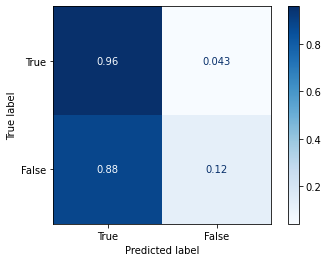

In [8]:
## Plot the confusion matrix (normalized
model.plot_confusion_matrix(x_test, y_test, normalize='true')

In [ ]:
## 10-Fold Cross-validation on the testing data
model.cross_validate(x_test, y_test)